In [1]:
import pandas as pd
import numpy as np

import re

import scipy.stats as sts

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from statsmodels.stats.outliers_influence import reset_ramsey
from itertools import combinations as comb
import statsmodels.api as sm
import nltk
from nltk.corpus import stopwords

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px

from wordcloud import WordCloud

plt.style.use('bmh')
sns.set_style("whitegrid")

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


добавим список из слов, что чаще всего используются в негативном ключе на английском и сопоставим тексты слов
с данным списком

In [3]:
bad_words = pd.read_csv('/content/drive/MyDrive/bad-words.csv')
bad_words = set(bad_words.jigaboo.to_list())

In [4]:
# создадим функцию, что будет подсчитывать количество использований слов в песнях исполнителей

def words_count(data):
    words_counter = {}

    for song in data.lyrics:
        for word in song:
            if len(word) > 1 or word in ['a', 'I']:
                words_counter[word] = words_counter.get(word, 0) + 1

    words_counter = dict(sorted(words_counter.items(), key=lambda x: x[1], reverse=True))
    return words_counter

дальше выполним функцию, что на выходе создаст, так называемое, "облако слов".
облако слов - в нашем случае, отображает используемые слова в песнях. величина слова зависит от количества использоавний слова

In [5]:
def make_word_cloud(data):
    text = ' '.join(words_count(data).keys())
    wordcloud = WordCloud(width=800, height=400, background_color='black').generate(text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

In [6]:
# функции представленные ниже выполняют примерно тоже самое, только работают уже с "плохими" словами

def bad_words_count(data):
    used_bad_words = bad_words.intersection(words_count(data).keys())
    BadWordsList = {}
    for word in used_bad_words:
        BadWordsList[word] = words_count(data)[word]

    return BadWordsList


def make_word_cloud_BadWordsEdition(data):
    text = ' '.join(bad_words_count(data).keys())
    wordcloud = WordCloud(width=800, height=400, background_color='black').generate(text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

In [7]:
positive_words_path = '/content/drive/MyDrive/positive-words.txt'
positive_words = set(pd.read_csv(positive_words_path, sep='\t').abound.to_list())

сделаем все тоже самое только для потизивных слов

In [8]:
def positive_words_count(data):
    used_positive_words = positive_words.intersection(words_count(data).keys())
    PositiveWordsList = {}
    for word in used_positive_words:
        PositiveWordsList[word] = words_count(data)[word]

    return PositiveWordsList

def make_word_cloud_PositiveWordsEdition(data):
    text = ' '.join(positive_words_count(data).keys())
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()


# Drake

приступим к работе с первым исполнителем. им в свою очередь будет [Drake](https://en.wikipedia.org/wiki/Drake_(musician)). так как в найденном датасете нет данных о дате выхода альбомов найдем их на вышеупомянутой странице артиста, они нам впоследствии пригодятся

In [9]:
albums = pd.read_html('https://en.wikipedia.org/wiki/Drake_discography')[1]

In [10]:
drake = pd.read_csv('/content/drive/MyDrive/drake_data.csv')
drake.track_views.fillna('0K', inplace=True)
drake.drop(index=263, inplace=True)
drake.track_views = np.array([float(num.replace('M', '').strip('\n')) * 10**6 if num[-1] == 'M'
                              else float(num.replace('K', '').strip('\n')) * 10**3
                              for num in drake.track_views.to_numpy()])
drake.rename({'lyrics_title': 'song', 'track_views': 'views'}, axis=1, inplace=True)
drake = drake[['album', 'song', 'lyrics', 'views']]
drake.lyrics = np.array([i.lower().replace('\n', '').replace(':', '').replace(':', '').
                         replace(',', '').replace('.', '').replace('?', '').
                         replace('!', '').replace('[', ' ').replace(']', ' ')
                         if type(i) == str else '' for i in drake.lyrics])
drake.lyrics = [i.split() for i in drake.lyrics]

In [11]:
# добавим колонку года

alb_det = albums['Album details']
alb_det = alb_det.squeeze('columns')
alb_det = alb_det.apply(lambda x: re.findall(r'\d+', x))
alb_det = alb_det.apply(lambda x: [element for element in x if len(element)==4][0])
albums['Album details'] = alb_det
albums = albums[['Title', 'Album details']]
albums.columns = albums.columns.droplevel()
albums = albums.rename(columns={'Title': 'album'})

drake = drake.merge(albums, left_on='album', right_on='album')
drake.rename({'Album details': 'year'}, axis=1, inplace=True)

In [12]:
drake

,album,song,lyrics,views,year
0,Certified Lover Boy,Certified Lover Boy* Lyrics,"[verse, put, my, feelings, on, icealways, been...",8700.0,2021
1,Certified Lover Boy,Like I’m Supposed To/Do Things Lyrics,"[verse, hands, are, tiedsomeone's, in, my, ear...",38800.0,2021
2,Certified Lover Boy,Not Around Lyrics,"[intro, yeah, we, backwassup, ladiesswishahous...",129800.0,2021
3,Certified Lover Boy,In the Cut (Ft. Roddy Ricch) Lyrics,"[intro, drake, ayy, yeahpipe, this, shit, up, ...",72100.0,2021
4,Certified Lover Boy,Zodiac Sign (Ft. Jessie Reyez) Lyrics,"[verse, 1, drake, you, ask, how, many, girls, ...",54800.0,2021
...,...,...,...,...,...
103,Thank Me Later,Cece's Interlude Lyrics,"[verse, 1, all, night, i've, been, staring, ca...",112500.0,2010
104,Thank Me Later,Find Your Love Lyrics,"[verse, 1, i'm, more, than, just, an, option, ...",314900.0,2010
105,Thank Me Later,Thank Me Now Lyrics,"[chorus, you, could, thank, me, now, go, 'head...",354600.0,2010
106,Thank Me Later,9AM in Dallas Lyrics,"[verse, these, are, my, one, st, thomas, flows...",377500.0,2010


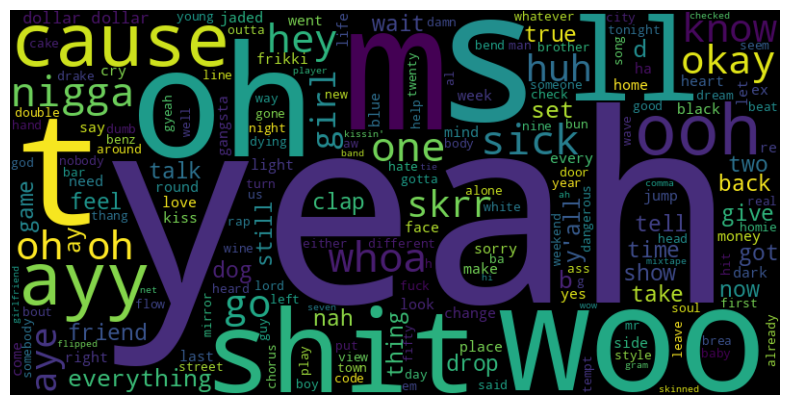

None


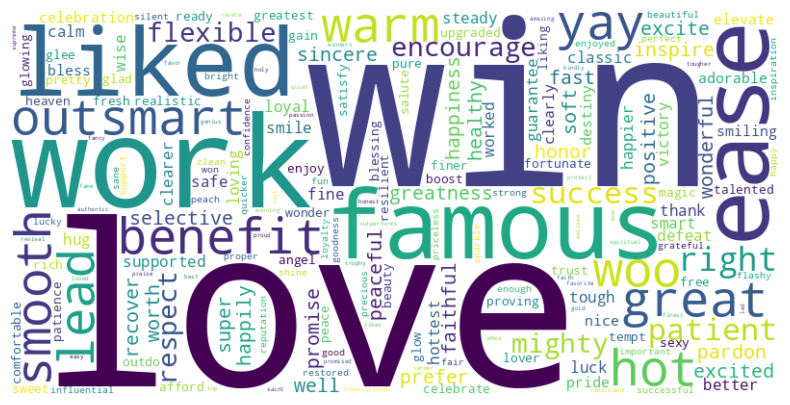

None


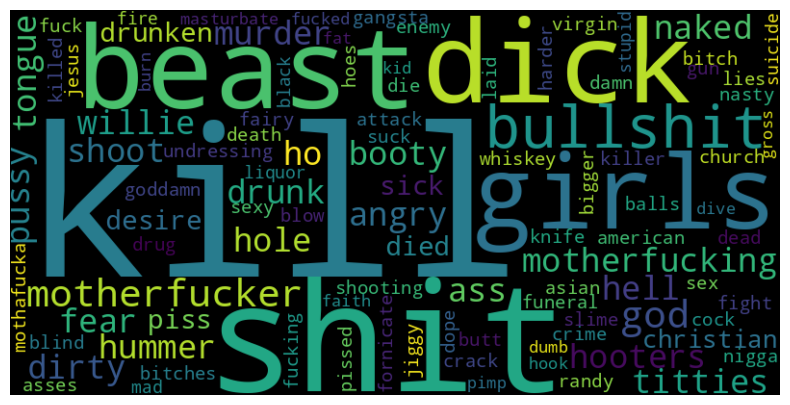

None


In [13]:
print(make_word_cloud(drake))
print(make_word_cloud_PositiveWordsEdition(drake))
print(make_word_cloud_BadWordsEdition(drake))

интересным показалось то, что исполнитель использует довольно часто слово - [Issa](https://ru.wikipedia.org/wiki/Иса_ибн_Марьям#:~:text=И́са%20ибн%20Ма́рьям%20аль%2DМаси́х,ислама%20—%20Инджиль%20(Евангелие).). причиной оказался [одноименный трек](https://genius.com/21-savage-issa-lyrics), который представлял из себя что-то подобное: `print('Issa ' * float('inf'))`. ироничным также кажется тот факт, что по какой-то причине слова _"библия", "малыш", "больше", "христианин", "Иисус", "иудей", "филипинцы"_ считаются "плохими"

# Eminem

воспроизведем те же манипуляции со следующим исполниелем - [Eminem](https://en.wikipedia.org/wiki/Eminem)

In [14]:
eminem = pd.read_csv('/content/drive/MyDrive/Eminem_Lyrics.csv', sep="\t", encoding='cp1252').iloc[:, :-1]
eminem.Views.fillna('0K', inplace=True)
eminem.drop(index=222, inplace=True)
eminem.Views = np.array([float(num.replace('M', '').strip('\n')) * 10**6 if num[-1] == 'M'
                         else float(num.replace('K', '').strip('\n')) * 10**3
                         for num in eminem.Views.to_numpy()])
eminem.Release_date.fillna(0, inplace=True)
eminem.Release_date = np.array([str(num[-4:]) if str(num) not in ['0', ' ', '2.7M']
                                else 0 for num in eminem.Release_date.to_numpy()])
eminem.rename({'Album_Name': 'album',
               'Song_Name': 'song',
               'Lyrics': 'lyrics',
               'Views': 'views',
               'Release_date': 'year'},
             axis=1, inplace=True)
eminem = eminem[['album', 'song', 'lyrics', 'year', 'views']]
eminem.lyrics = np.array([i.lower().replace('\n', '').replace(':', '').replace(':', '').
                         replace(',', '').replace('.', '').replace('?', '').
                         replace('!', '').replace('[', ' ').replace(']', ' ')
                         if type(i) == str else '' for i in eminem.lyrics])
eminem.lyrics = [i.split() for i in eminem.lyrics]

In [15]:
eminem

,album,song,lyrics,year,views
0,Music To Be Murdered By: Side B,Alfred (Intro),"[intro, alfred, hitchcock, thus, far, this, al...",2020,24300.0
1,Music To Be Murdered By: Side B,Black Magic,"[chorus, skylar, grey, &, eminem, black, magic...",2020,180600.0
2,Music To Be Murdered By: Side B,Alfred’s Theme,"[verse, 1, before, i, check, the, mic, (check,...",2020,285600.0
3,Music To Be Murdered By: Side B,Tone Deaf,"[intro, yeah, i'm, sorry, (huh)what, did, you,...",2020,210900.0
4,Music To Be Murdered By: Side B,Book of Rhymes,"[intro, i, don't, smile, i, don't, frown, get,...",2020,193300.0
...,...,...,...,...,...
343,Unreleased Songs,Listen To Your Heart,"[chorus, roxette, i, know, there's, something,...",0,65500.0
344,Unreleased Songs,I Get Money (Remix),"[intro, yeah, yeah, i, get, iti, run, this, ra...",0,28500.0
345,Unreleased Songs,Cut Back,"[verse, i, cut, back, on, the, syllables, just...",2007,0.0
346,Unreleased Songs,Hip Hop,"[intro, c'mon, verse, i, still, remember, the,...",2007,0.0


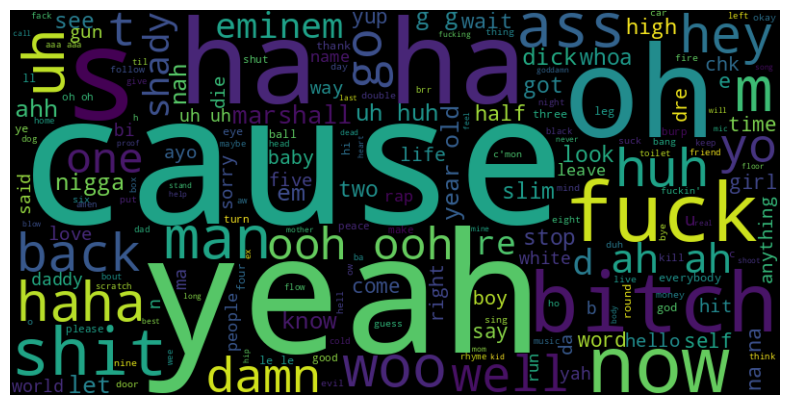

None


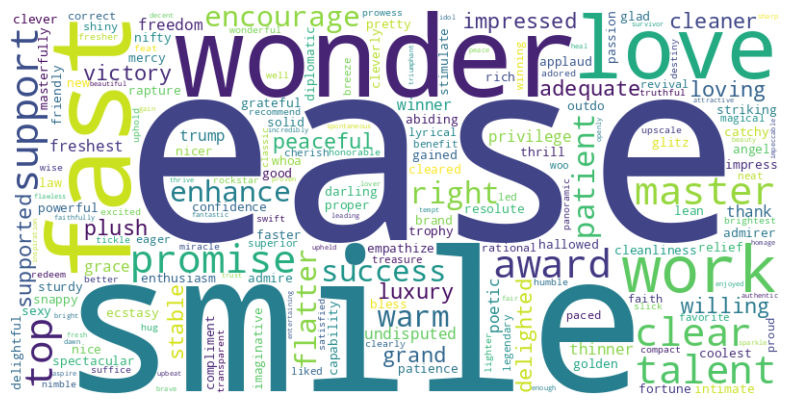

None


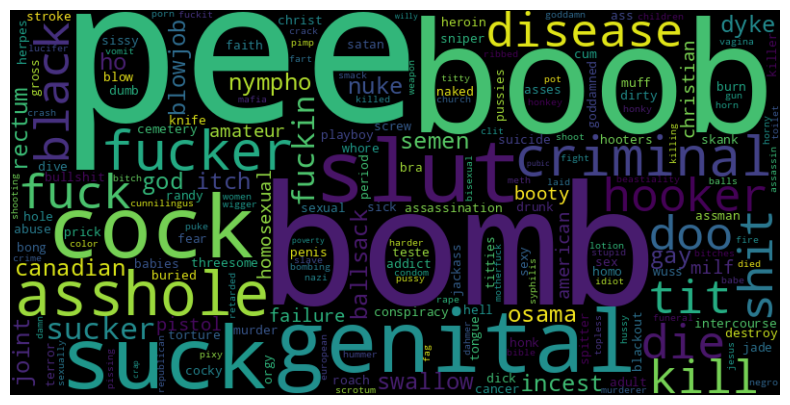

None


In [16]:
print(make_word_cloud(eminem))
print(make_word_cloud_PositiveWordsEdition(eminem))
print(make_word_cloud_BadWordsEdition(eminem))

# Rihanna

очередь дошла и до единственного жеского, тем более [R&B](https://en.wikipedia.org/wiki/Rhythm_and_blues) исполнителя - [Rihanna](https://ru.wikipedia.org/wiki/%D0%A0%D0%B8%D0%B0%D0%BD%D0%BD%D0%B0). (не сочтите за сексизм, исполнители представлены в случайном порядке)

In [17]:
rihanna = pd.read_csv('/content/drive/MyDrive/Rihanna Lyrics.csv', sep=";", encoding='cp1252')
rihanna.lyrics = np.array([i.lower().replace('\n', '').replace(':', '').replace(':', '').
                         replace(',', '').replace('.', '').replace('?', '').
                         replace('!', '').replace('[', ' ').replace(']', ' ')
                         if type(i) == str else '' for i in rihanna.lyrics])
rihanna.lyrics = [i.split() for i in rihanna.lyrics]

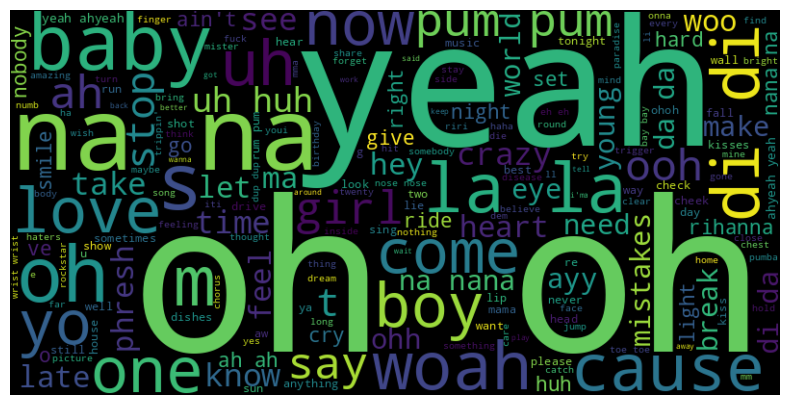

None


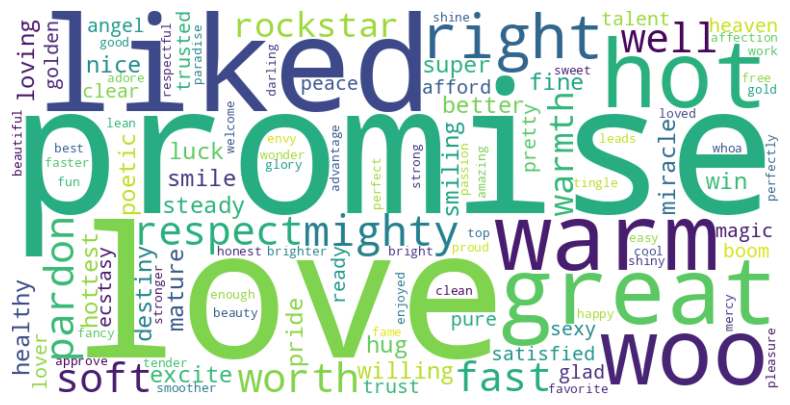

None


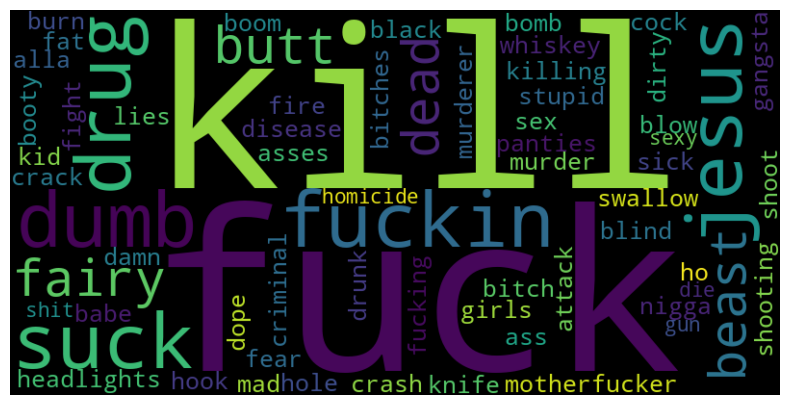

None


In [18]:
print(make_word_cloud(rihanna))
print(make_word_cloud_PositiveWordsEdition(rihanna))
print(make_word_cloud_BadWordsEdition(rihanna))

## Новые параметры

Так как идея нашего проекта, непосредственно, показать взаимосвязть слов в песне, какими бы они не были, далее мы разберем влияние всех типов, мы несколько ограничены в выборе параметров. Давайте посмотрим, что нам получилось добавить в модель:

настала пора добавить первый параметр в датасеты, а именно количество "плохих" и "хороших" слов в песнях

In [19]:
def words_list(data, word_set):
    word_cnt = [[1 for word in song if word in word_set] for song in data.lyrics]
    word_cnt = [sum(i) for i in word_cnt]

    return word_cnt

for singer in [drake, eminem, rihanna]:
    singer['bad_word_count'] = words_list(singer, bad_words)
    singer['positive_word_count'] = words_list(singer, positive_words)

все мы знаем хотя бы одну назойливую песня с повторяющимся мотивом, что не выходит из головы и в которой наверняка есть куча повторяющихся незамысловатых конструкций, по типу: "ла-ла-ла", "на-на-на", "у-у-у-у" и т.д. и т.п. или же в песне просто крутиться припев 8 раз подряд, который потом мешает вам существовать и возникает у вас в голове при любой удобной и не очень ситуации. давайте же проверим, зависит ли популярность песни от наличия таких вставок или же наоборот, такого рода песня будет только

In [20]:
def count_same_words(data):
    data['unique_words_ratio'] = [len(set(song))/len(song) if len(song) > 0 else 0 for song in data.lyrics]
    data['song_lenght'] = [len(song) for song in data.lyrics]

for singer in [drake, eminem, rihanna]:
    count_same_words(singer)

добавим также один спорный параметр. им будет количество слов в названии песни. должно ли название быть кратким и броским или же всем плевать? давайте в дальнейшем проверим это с помощью гипотезы о незначимости параметра (shout-out to BB)

In [21]:
def song_title_lenght(data):
    song_title_lenght = [song.replace('\n', '').replace(':', '').replace(':', '').replace(')', '').
                         replace(',', '').replace('.', '').replace('?', '').replace(')', '').
                         replace('!', '').replace('[', ' ').replace(']', ' ')
                         for song in data.song]
    song_title_lenght = [len(song.split()) for song in data.song]
    data['song_title_lenght'] = song_title_lenght

for singer in [drake, eminem, rihanna]:
    song_title_lenght(singer)

Исследователи из Университета Кертина (Австралия) изучили 271 песню, с 1999 по 2014 год появлявшуюся в британском чарте. Их интересовала беглость обработки текста песни, то есть насколько легко и быстро наш мозг обрабатывает предлагаемую информацию. Это неминуемо влияет на то, как мы эту информацию воспринимаем — «слишком сложно и занудно» или «просто и зажигательно».Тексты песен обрабатывала компьютерная программа, которая оценивала их удобочитаемость и общую сложность текста. Популярность исследователи оценивали по тому, какую позицию и как долго песня занимала в еженедельных чартах. Оказалось, чем проще мозг слушателя воспринимал текст песни, тем большей популярности она добивалась, занимая наивысшие позиции в чартах.

Добавим новый признак,который отражает среднее количество букв в слове по тексту песни.

In [22]:
def measure_averageLenght(data):
    data['average_word_length'] = data['lyrics'].apply(lambda x:
                                                     sum(len(word) for word in x) / len(x)
                                                     if len(x) > 0 else 0)

for singer in [drake, eminem, rihanna]:
    measure_averageLenght(singer)

создадим корреляционную матрицу слов для нахождения схожести между словами в песнях. впоследствии, добавим параметр корреляции слов в песне с самой популярной песней исполнителя. данный показатель должен продемонстрировать, должны ли популярные у исполнителя композиции быть похожи друг на друга

In [23]:
def make_words_corr_matrix(data):

    songs = [' '.join(song) for song in data.lyrics]
    X = CountVectorizer().fit_transform(songs)
    word_matrix = X.toarray()

    correlation_matrix = cosine_similarity(word_matrix)
    corr_matrix = pd.DataFrame(data=correlation_matrix, index=data.song, columns=data.song)

    return corr_matrix


def count_corr(data):
    banger = make_words_corr_matrix(data).iloc[data.views.idxmax()].to_numpy()
    data['corr_with_banger'] = banger

for singer in [drake, eminem, rihanna]:
    count_corr(singer)

дальше идет параметр возраста исполнителя во время выходы трека. также пара dummy-переменных: пол и раса исполнителя

In [24]:
# возраст исполнителя во время релиза
birth = [1986, 1972, 1988]
def age_counter(data, birth_year):
    data['year'] = pd.to_numeric(data['year'], errors='coerce')
    data['age_at_release'] = data['year'] - birth_year
    data['age_at_release'].replace({-birth_year: 0.0}, inplace=True)

# 1 - male, 0 - female
sex = [np.ones(drake.shape[0]),
       np.ones(eminem.shape[0]),
       np.zeros(rihanna.shape[0])]
# 1 - white, 0 - not white
race = [np.zeros(drake.shape[0]),
        np.ones(eminem.shape[0]),
        np.zeros(rihanna.shape[0])]

cnt = 0
together = pd.DataFrame()

for singer in [drake, eminem, rihanna]:
    df_copy = singer.copy()
    df_copy['race'] = race[cnt]
    df_copy['sex'] = sex[cnt]
    age_counter(df_copy, birth[cnt])
    together = pd.concat([together,df_copy])
    cnt += 1

together.head()

,album,song,lyrics,views,year,bad_word_count,positive_word_count,unique_words_ratio,song_lenght,song_title_lenght,average_word_length,corr_with_banger,race,sex,age_at_release
0,Certified Lover Boy,Certified Lover Boy* Lyrics,"[verse, put, my, feelings, on, icealways, been...",8700.0,2021.0,0,1,1.000000,18,4,5.500000,0.125649,0.0,1.0,35.0
1,Certified Lover Boy,Like I’m Supposed To/Do Things Lyrics,"[verse, hands, are, tiedsomeone's, in, my, ear...",38800.0,2021.0,0,3,0.418301,153,6,4.450980,0.188377,0.0,1.0,35.0
2,Certified Lover Boy,Not Around Lyrics,"[intro, yeah, we, backwassup, ladiesswishahous...",129800.0,2021.0,12,11,0.351816,523,3,4.196941,0.345414,0.0,1.0,35.0
3,Certified Lover Boy,In the Cut (Ft. Roddy Ricch) Lyrics,"[intro, drake, ayy, yeahpipe, this, shit, up, ...",72100.0,2021.0,4,12,0.535826,321,7,4.199377,0.280236,0.0,1.0,35.0
4,Certified Lover Boy,Zodiac Sign (Ft. Jessie Reyez) Lyrics,"[verse, 1, drake, you, ask, how, many, girls, ...",54800.0,2021.0,6,17,0.570048,414,6,4.413043,0.360198,0.0,1.0,35.0


<Figure size 1500x1500 with 0 Axes>

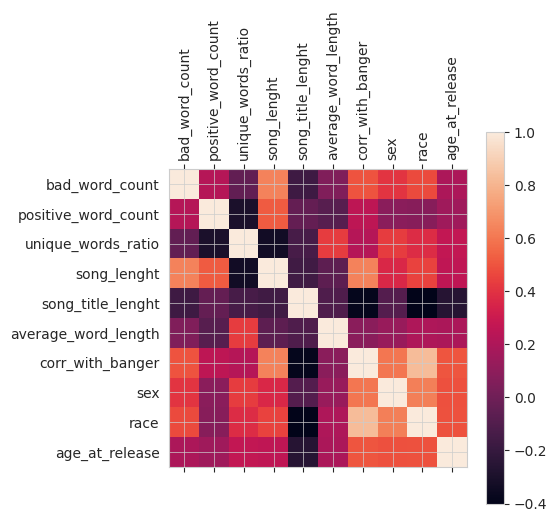

In [25]:
features = np.array(['bad_word_count', 'positive_word_count', 'unique_words_ratio',
            'song_lenght','song_title_lenght','average_word_length',
            'corr_with_banger', 'sex', 'race', 'age_at_release'])

plt.figure(figsize=(15, 15))
plt.matshow(together[features].corr())
plt.xticks(ticks=range(len(features)), labels=features, rotation=90)
plt.yticks(ticks=range(len(features)), labels=features)
cb = plt.colorbar()

дабы убедиться в том, что нас обошла стороной мультиколлениарность, вывели heatmap, далее была реализована функция, что в свою очередь, изображает корреляционные матрицы в более приближенном формате, но уже глядя на выше представленный график, можем убедиться, что значий корреляции между регрессорами больше чем ~0.6 нет

## Анализ


создателем датасета было заверено, что к некоторым песням не было получено доступа для изъятия информации, из-за чего информация была собрана не полностью. те треки, собрать данные по которым не доставилось возможности, в колонке `views` просто занулили. поэтому имеем полное право не включать их в наше исследование

In [26]:
together.drop(index=together[together.year.isna()].index, inplace=True)
together = together[together.views > 0]
together['log_views'] = np.log(together['views'])

<ipython-input-26-4405a8a9477c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  together['log_views'] = np.log(together['views'])


## Шкалирование выборки



In [27]:
minmax = MinMaxScaler()
together_minmax = pd.DataFrame(minmax.fit_transform(together[features]),
                               columns = together.drop(columns=['views', 'album','song', 'lyrics','year','log_views']).columns)
together_minmax['log_views'] = together.reset_index(drop=True)['log_views']

together_minmax

,bad_word_count,positive_word_count,unique_words_ratio,song_lenght,song_title_lenght,average_word_length,corr_with_banger,race,sex,age_at_release,log_views
0,0.000000,0.011494,1.000000,0.012346,0.333333,0.715447,0.125649,1.0,0.0,0.729167,9.071078
1,0.000000,0.034483,0.418301,0.104938,0.555556,0.578989,0.188377,1.0,0.0,0.729167,10.566176
2,0.112150,0.126437,0.351816,0.358711,0.222222,0.545944,0.345414,1.0,0.0,0.729167,11.773750
3,0.037383,0.137931,0.535826,0.220165,0.666667,0.546260,0.280236,1.0,0.0,0.729167,11.185809
4,0.056075,0.195402,0.570048,0.283951,0.555556,0.574054,0.360198,1.0,0.0,0.729167,10.911445
...,...,...,...,...,...,...,...,...,...,...,...
527,0.028037,0.034483,0.777778,0.074074,0.000000,0.549232,0.236535,0.0,0.0,0.583333,13.250932
528,0.009346,0.068966,0.522013,0.109053,0.222222,0.582502,0.344148,0.0,0.0,0.583333,13.131125
529,0.000000,0.000000,0.032172,0.255830,0.111111,0.488241,0.023684,0.0,0.0,0.583333,11.855806
530,0.074766,0.068966,0.544379,0.115912,0.000000,0.590369,0.235264,0.0,0.0,0.583333,12.409422


In [28]:
scaler = StandardScaler()
together_scaled = pd.DataFrame(scaler.fit_transform(together[features]),
                               columns = together.drop(columns=['views', 'album','song', 'lyrics','year','log_views']).columns)
together_scaled['log_views'] = together.reset_index(drop=True)['log_views']

together_scaled

,bad_word_count,positive_word_count,unique_words_ratio,song_lenght,song_title_lenght,average_word_length,corr_with_banger,race,sex,age_at_release,log_views
0,-1.089390,-1.389535,4.621178,-2.177415,0.600659,2.794306,-1.749013,0.469237,-1.268008,0.409085,9.071078
1,-1.089390,-1.204704,-0.411080,-1.669939,1.781993,-0.057119,-1.460049,0.469237,-1.268008,0.409085,10.566176
2,-0.164936,-0.465379,-0.986233,-0.279077,0.009992,-0.747644,-0.736632,0.469237,-1.268008,0.409085,11.773750
3,-0.781239,-0.372963,0.605623,-1.038412,2.372660,-0.741022,-1.036882,0.469237,-1.268008,0.409085,11.185809
4,-0.627163,0.089115,0.901683,-0.688817,1.781993,-0.160238,-0.668523,0.469237,-1.268008,0.409085,10.911445
...,...,...,...,...,...,...,...,...,...,...,...
527,-0.858276,-1.204704,2.698742,-1.839098,-1.171341,-0.678925,-1.238200,-2.131119,-1.268008,-0.368573,13.250932
528,-1.012352,-0.927457,0.486128,-1.647384,0.009992,0.016291,-0.742463,-2.131119,-1.268008,-0.368573,13.131125
529,-1.089390,-1.481951,-3.751468,-0.842940,-0.580674,-1.953400,-2.218734,-2.131119,-1.268008,-0.368573,11.855806
530,-0.473087,-0.927457,0.679616,-1.609793,-1.171341,0.180671,-1.244055,-2.131119,-1.268008,-0.368573,12.409422


In [29]:
def scaled_model(data):
    X = data[features]
    y = data['log_views']
    X = sm.add_constant(X)

    y.reset_index(drop=True, inplace=True)
    X.reset_index(drop=True, inplace=True)

    model = sm.OLS(y, X).fit()

    print(model.summary())

In [30]:
print(scaled_model(together))
print(scaled_model(together_minmax))
print(scaled_model(together_scaled))

                            OLS Regression Results                            
Dep. Variable:              log_views   R-squared:                       0.356
Model:                            OLS   Adj. R-squared:                  0.343
Method:                 Least Squares   F-statistic:                     28.76
Date:                Sun, 10 Dec 2023   Prob (F-statistic):           6.08e-44
Time:                        20:43:38   Log-Likelihood:                -892.61
No. Observations:                 532   AIC:                             1807.
Df Residuals:                     521   BIC:                             1854.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   8.2759    

видим что разницы между нормированием от 0 до 1 и стандартизацией не было выявлено

In [31]:
#данными списками можно воспользоваться при желании получить графики корреляционных для всех возможных пар параметров
column_list = [value for value in list(together.columns) if value not in ['album', 'song', 'lyrics', 'views', 'year', 'log_views']]
pares = list(comb(column_list, 2))

# создадим функцию, что при необходимости, будет выдавать график корреляционной матрицы между двумя параметрами модели
def cor_graph(val1, val2):
    selected_variables = [val1, val2]
    subset_data = together[selected_variables]
    correlation_matrix = subset_data.corr()

    plt.figure(figsize=(5, 3))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
    plt.title(f"Correlation Matrix between {val1} & {val2}")
    plt.show()

In [32]:
def model(data):
    X = data[features]
    y = data['log_views']
    X = sm.add_constant(X)

    y.reset_index(drop=True, inplace=True)
    X.reset_index(drop=True, inplace=True)

    m = sm.OLS(y, X).fit()

    return m

посмотрим насколько сильно предсказание модели отклоняется от истинного значения целевой переменной

In [33]:
test = together_minmax.sample(20)
X_test = test[features]
Y_test = test['log_views']
dummy_model = model(together_minmax)
X_test = sm.add_constant(X_test)
Y_pred = dummy_model.predict(X_test)
# Y_pred = dummy_model.predict(X_test.reset_index(drop=True, inplace=True))
df_comp = pd.DataFrame({'Test': Y_test, 'Predicted': Y_pred, 'Difference': np.array(Y_test)-np.array(Y_pred)})
df_comp

,Test,Predicted,Difference
29,15.789592,14.054516,1.735075
526,14.603968,11.657607,2.946361
30,13.726461,12.823755,0.902706
73,14.403297,13.186688,1.216609
334,12.507288,11.924538,0.582750
477,9.409191,10.857114,-1.447923
192,12.692196,12.854161,-0.161965
12,14.151983,14.182948,-0.030965
198,12.456053,12.323698,0.132355
148,13.321542,12.049732,1.271810


# Гипотезы

<font color='pink'> Тест Чоу

известно, что для исполнителей представляющих разные социальные/этнические группы существуют свои стереотипы и образы, принадлежность которым может влиять на факторы успеха. проверим гипотезу о том, что влияние взятых нами факторов на популярность песни для мужских и женских исполнителей различается - используем для этого тест Чоу, взяв за уровень значимости 5%



In [34]:
X = together[features]
y = together['log_views']
X = sm.add_constant(X)
model_full = sm.OLS(y.reset_index(drop=True), X.reset_index(drop=True)).fit()

features_sub = ['bad_word_count', 'positive_word_count', 'unique_words_ratio',
       'song_lenght', 'song_title_lenght', 'average_word_length',
       'corr_with_banger', 'race', 'age_at_release']
X_male = together[together['sex']==1][features_sub]
y_male = together[together['sex']==1]['log_views']
X_male = sm.add_constant(X_male)
model_male = sm.OLS(y_male, X_male).fit()

X_female = together[together['sex']==0][features_sub]
y_female = together[together['sex']==0]['log_views']
X_female = sm.add_constant(X_female)
model_female = sm.OLS(y_female, X_female).fit()

RSS_full = sum(model_full.resid ** 2)
RSS_1 = sum(model_male.resid ** 2)
RSS_2 = sum(model_female.resid ** 2)

numerator = ((RSS_full - (RSS_1 + RSS_2))/ (len(features)+1))
denominator = ((RSS_1 + RSS_2) / (len(X)-2*len(features)+1))
f_stat = numerator / denominator

f_crit = sts.f.ppf(0.95,len(features), len(X)-2*len(features))

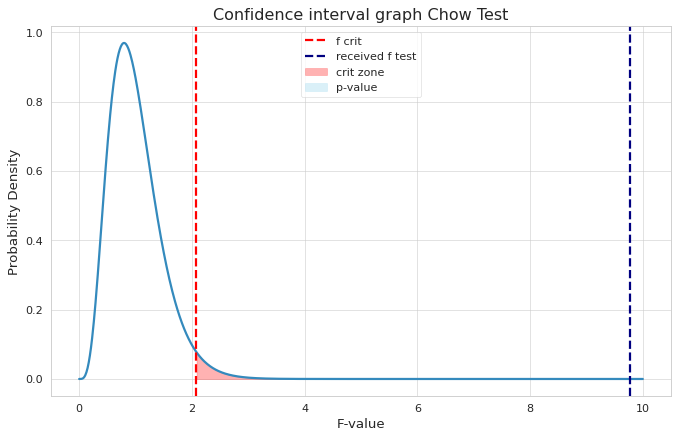

In [35]:
plt.figure(figsize=(10, 6), dpi=80)
x = np.linspace(0, 10, 1000)
f_dist = sts.f.pdf(x,len(features), len(X)-2*len(features))
plt.plot(x, f_dist)
f_test = f_stat
f_crit = sts.f.ppf(0.975, len(features), len(X)-2*len(features))
plt.axvline(f_crit, color='r', linestyle='--', label='f crit')
plt.axvline(f_test, color='navy', linestyle='--', label='received f test')
plt.fill_between(x, 0, f_dist, where=(x > f_crit), color='r', alpha=0.3, label='crit zone')
plt.fill_between(x, 0, f_dist, where=(x > f_test), color='skyblue', alpha=0.3, label='p-value')


plt.xlabel('F-value')
plt.ylabel('Probability Density')
plt.legend()
plt.title('Confidence interval graph Chow Test')

plt.show()

значение полученной f-статистики (9.77) сильно выше f-критического - гипотеза об однородности взаимосвязей для мужчин и женщин отвергается

---


In [36]:
print(model_male.summary())

                            OLS Regression Results                            
Dep. Variable:              log_views   R-squared:                       0.369
Model:                            OLS   Adj. R-squared:                  0.356
Method:                 Least Squares   F-statistic:                     27.67
Date:                Sun, 10 Dec 2023   Prob (F-statistic):           1.02e-37
Time:                        20:43:38   Log-Likelihood:                -699.16
No. Observations:                 436   AIC:                             1418.
Df Residuals:                     426   BIC:                             1459.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  10.7224    

In [37]:
print(model_female.summary())

                            OLS Regression Results                            
Dep. Variable:              log_views   R-squared:                       0.592
Model:                            OLS   Adj. R-squared:                  0.554
Method:                 Least Squares   F-statistic:                     15.75
Date:                Sun, 10 Dec 2023   Prob (F-statistic):           4.14e-14
Time:                        20:43:38   Log-Likelihood:                -141.59
No. Observations:                  96   AIC:                             301.2
Df Residuals:                      87   BIC:                             324.3
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -1.7387    

/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:1965: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])


теперь выполним тест Рамсея, дабы убедиться, что нам не стоит в модель новые нелинейные параметры

In [38]:
reset_ramsey(model(together), degree=5)

<class 'statsmodels.stats.contrast.ContrastResults'>
<F test: F=0.5366165928680431, p=0.7088972186098792, df_denom=517, df_num=4>

по результатам теста, можно заметить, что нет необходимости включать в модель нелинейные аналоги наших переменных

__________________________________________

проверили лассо-регрессию, дабы в случае чего, занулились параметры

In [39]:
def model_regularized(data):
    X = data[features]
    y = data['log_views']
    X = sm.add_constant(X)

    y.reset_index(drop=True, inplace=True)
    X.reset_index(drop=True, inplace=True)

    m = sm.OLS(y, X).fit_regularized()

    return m

In [40]:
model_regularized(together).params

const                  10.579954
bad_word_count          0.002385
positive_word_count     0.003275
unique_words_ratio     -0.055267
song_lenght             0.002132
song_title_lenght      -0.123497
average_word_length    -0.062851
corr_with_banger        0.521171
sex                     1.909496
race                   -2.330609
age_at_release          0.025698
dtype: float64

ниже представлен тест Колмагорова-Смирнова и, как можно заметить по p-value, гипотеза о схожести распределения просмотров для исполнителей отвергается для всех пар исполнителей

In [41]:
from scipy.stats import ks_2samp

def ks_test(data1, data2):
    stat, p_value = ks_2samp(data1, data2)
    return stat, p_value

stat_1_2, p_value_1_2 = ks_test(drake.views.to_numpy(), eminem.views.to_numpy())
stat_1_3, p_value_1_3 = ks_test(drake.views.to_numpy(), rihanna.views.to_numpy())
stat_2_3, p_value_2_3 = ks_test(eminem.views.to_numpy(), rihanna.views.to_numpy())

# Вывод результатов теста
print(f"t-stat = {stat_1_2}, p-value = {p_value_1_2}")
print(f"t-stat = {stat_1_3} p-value = {p_value_1_3}")
print(f"t-stat = {stat_2_3}, p-value = {p_value_2_3}")

t-stat = 0.4813747465044295, p-value = 6.669035524981419e-18
t-stat = 0.7030481809242871 p-value = 6.898435642326645e-27
t-stat = 0.3016245441330239, p-value = 2.3107749158598208e-07


In [42]:
test_res = np.array([model(together.sample(250)).rsquared for i in range(1000)])
print(f'нижняя граница = {np.quantile(test_res, 0.025)}, верхняя граница = {np.quantile(test_res, 0.0975)}')

нижняя граница = 0.3073949292079701, верхняя граница = 0.328236472110953


In [43]:
def make_f_test(data):
    X = data[features]
    y = data['log_views']
    X = sm.add_constant(X)

    def model(data):
      y.reset_index(drop=True, inplace=True)
      X.reset_index(drop=True, inplace=True)

      m = sm.OLS(y, X).fit()
      return m

    f_test_res = model(data).f_test(np.identity(X.shape[1]))
    return f_test_res

In [44]:
make_f_test(together)

<class 'statsmodels.stats.contrast.ContrastResults'>
<F test: F=4397.942588886416, p=0.0, df_denom=521, df_num=11>

для пущей уверенности, стоило проверить также, тест об адекватности (значимости) регрессии, который показал в свою очередь, что нулевая гипотеза отвергается, а значит, что подозрения о незначимости модели пропадают окончательно

In [45]:
def make_t_test(data, val1, val2, method='not_abs', alpha=0.05):
    param1 = data[val1].to_numpy()
    param2 = data[val2].to_numpy()
    data_for_test = data.copy()

    if method == 'abs':
        param1 = np.abs(data[val1].to_numpy())
        param2 = np.abs(data[val2].to_numpy())
        data_for_test[val1], data_for_test[val2] = param1, param2

    beta1 = model(data_for_test).params[val1]
    beta2 = model(data_for_test).params[val2]
    df = len(param1)-len(features)

    t_test = (beta1 - beta2)/np.std(param1)
    t_crit = sts.t.ppf(1-alpha/2, df=df)

    print(f't-stat: {t_test}, t-crit: {t_crit}, df: {df}')

    plt.figure(figsize=(10, 6), dpi=80)
    df = df
    x = np.linspace(-4, 4, 1000)
    t_dist = sts.t.pdf(x, df)
    plt.plot(x, t_dist, color='slateblue')
    t_crit = sts.t.ppf(1-alpha/2, df)
    plt.axvline(t_crit, color='navy', linestyle='--', label='t crit')
    plt.axvline(-t_crit, color='navy', linestyle='--', label='-t crit')
    plt.axvline(t_test, color='red', linestyle='--', label='received t-test')
    plt.fill_between(x, 0, t_dist, where=(x > t_crit), color='navy', alpha=0.3, label='crit zone')
    plt.fill_between(x, 0, t_dist, where=(x < -t_crit), color='navy', alpha=0.3, label='crit zone')
    plt.fill_between(x, 0, t_dist, where=(x > t_test), color='skyblue', alpha=0.3, label='p-value')


    plt.xlabel('t-value')
    plt.ylabel('Probability Density')
    plt.legend()
    plt.title('Confidence interval graph')

    plt.show()

t-stat: -0.0007971282510615247, t-crit: 1.9655482824699675, df: 426


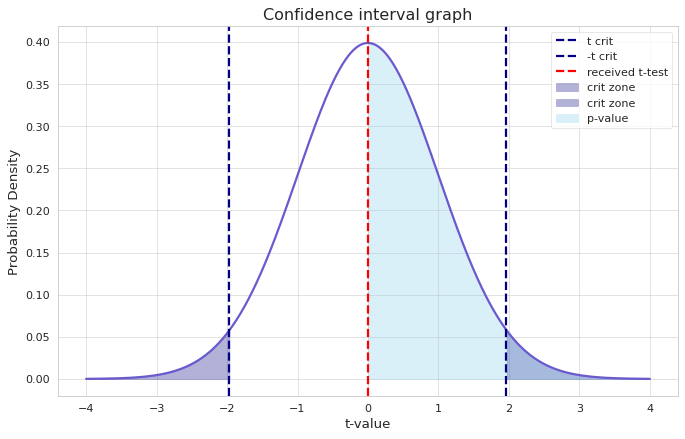

In [46]:
make_t_test(together[together['sex']==1], 'positive_word_count', 'bad_word_count', method='abs', alpha=0.05)

t-stat: 0.0013563821764622386, t-crit: 1.9879342060816718, df: 86


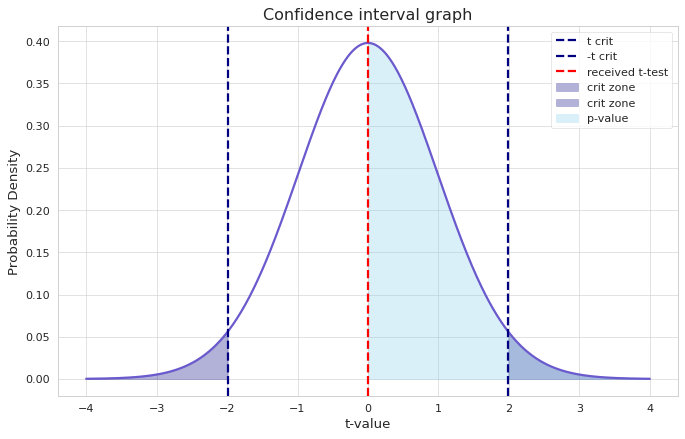

In [47]:
make_t_test(together[together['sex']==0], 'positive_word_count', 'bad_word_count', method='abs', alpha=0.05)

______

Распределение признаков регрессоров

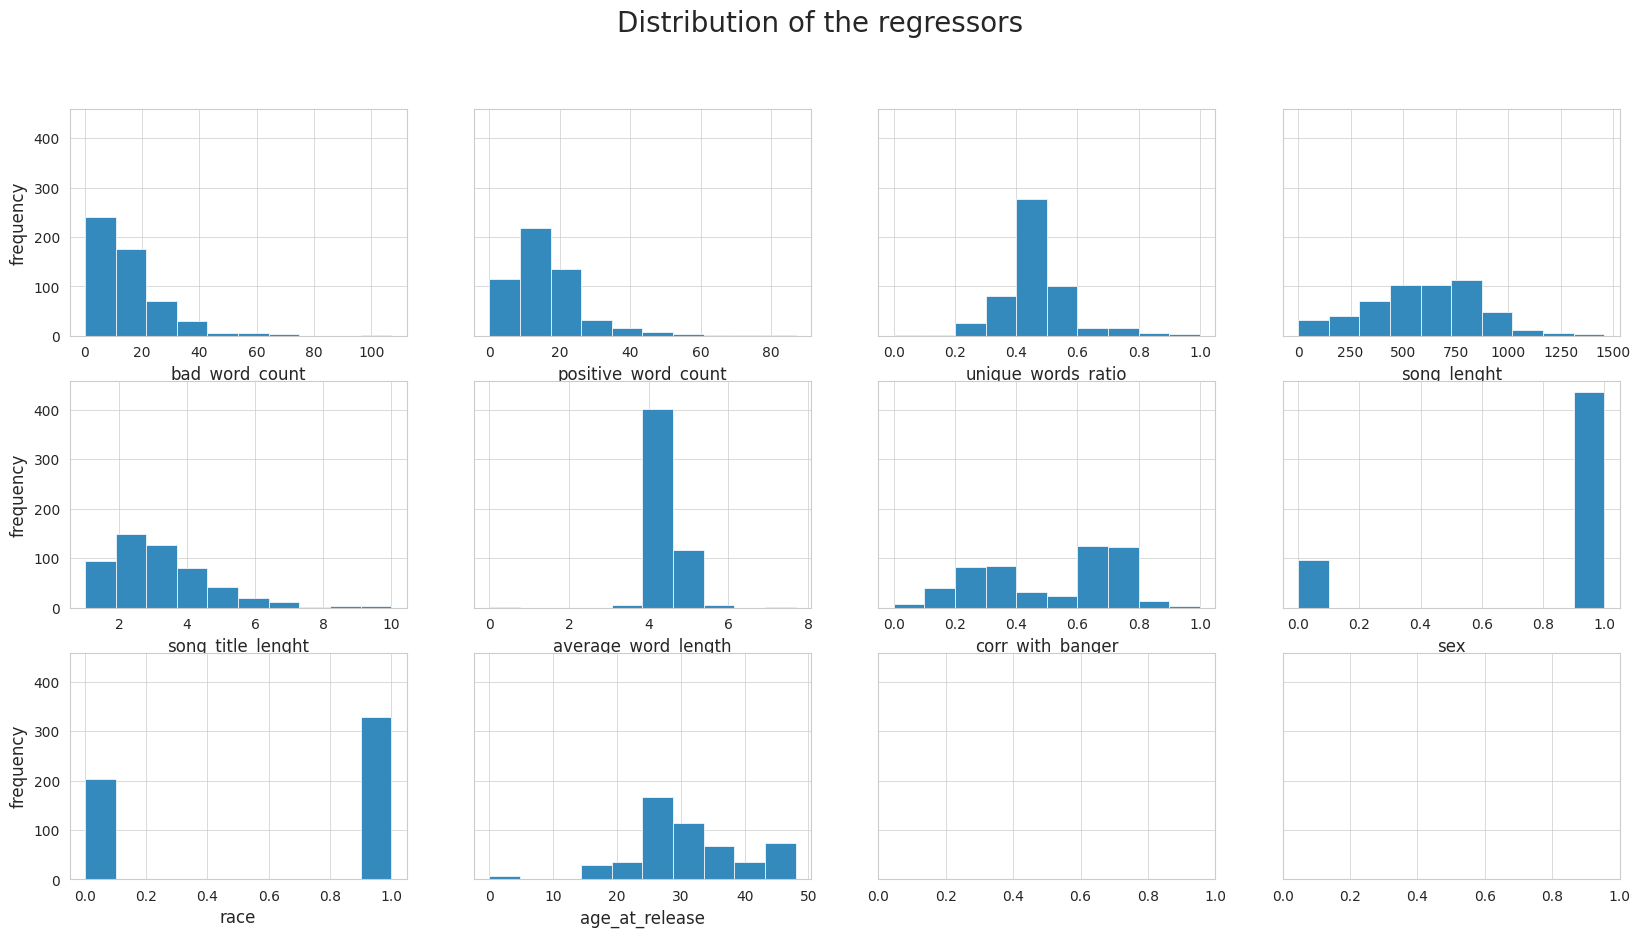

In [48]:
def plot_graphs(data, features):
    fig, axes = plt.subplots(3, 4, figsize=(20, 10), sharey=True)
    x = 0
    for i in range(3):
        for j in range(4):
          axes[i, j].hist(data[features[x]])
          axes[i, j].set_xlabel(features[x])
          x += 1
          if j == 0:
            axes[i, j].set_ylabel('frequency')
          if x==10:
            break

    fig.suptitle('Distribution of the regressors', fontsize=20)
    plt.show()

plot_graphs(together, features)

__________________________

Визуализация данных: Влияние категориальных признаков на распределение целевой переменной

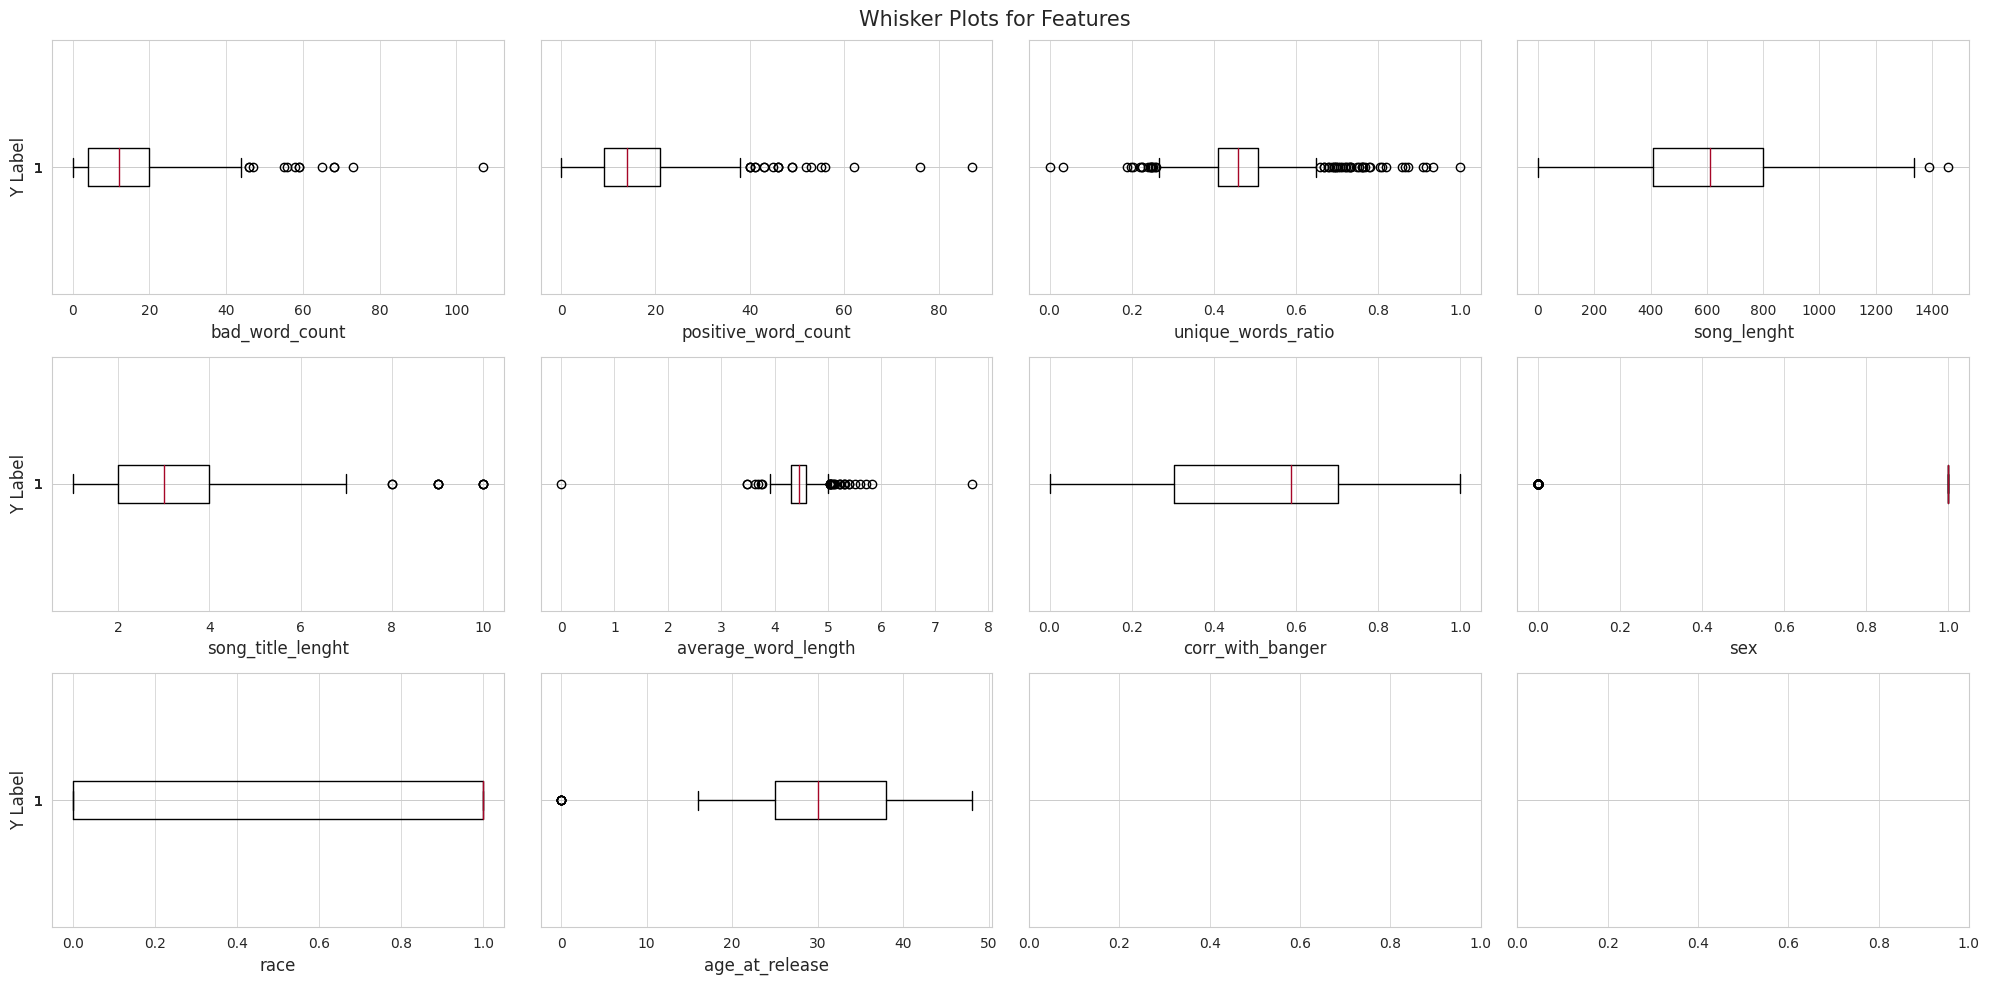

In [49]:
def plot_whisker(data, features):
    fig, axes = plt.subplots(3, 4, figsize=(20, 10), sharey=True)
    x= 0
    for i in range(3):
      for j in range(4):
        axes[i, j].boxplot(data[features[x]], vert=False)
        axes[i, j].set_xlabel(features[x])
        x += 1
        if j == 0:
          axes[i, j].set_ylabel('Y Label')
        if x==10:
          break

    fig.suptitle("Whisker Plots for Features", fontsize=15)
    plt.tight_layout()
    plt.show()

plot_whisker(together, features)

In [50]:
together.reset_index(drop=True, inplace=True)

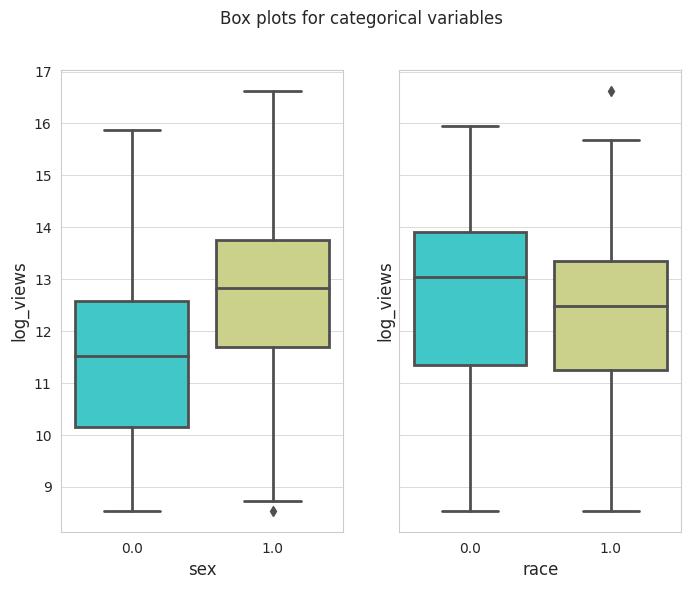

In [51]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 6), sharey=True)
fig.suptitle('Box plots for categorical variables')

sns.boxplot(x="sex", y="log_views", data=together, palette='rainbow', ax=ax1)
ax1.set_xlabel('sex')

sns.boxplot(x="race", y="log_views", data=together, palette='rainbow', ax=ax2)
ax2.set_xlabel('race')

plt.show()

Мы можем наблюдать, что пол исполнителя оказывает влияние на распределение целевой переменной (мужчины-исполнители имеют более высокое число просмотров), в то время как цвет кожи оказывает значительно меньшее влияние.

Посмотрим на баланс классов в категориальных переменных

Text(0.5, 1.0, 'Class balance in "sex" variable')

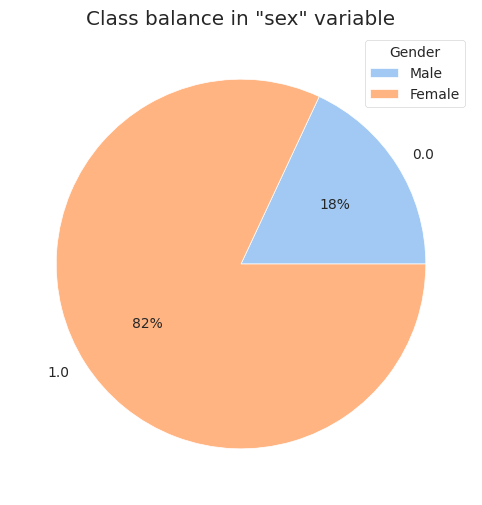

In [52]:
colors = sns.color_palette('pastel')[0:5]
shares = together.groupby('sex').size()
legend_labels = ['Male','Female']

plt.figure(figsize=(8,6))
plt.pie(shares, labels = shares.index, colors = colors, autopct='%.0f%%')
plt.legend(title='Gender', labels=legend_labels, loc='best')
plt.title('Class balance in "sex" variable')

Text(0.5, 1.0, 'Class balance in "race" variable')

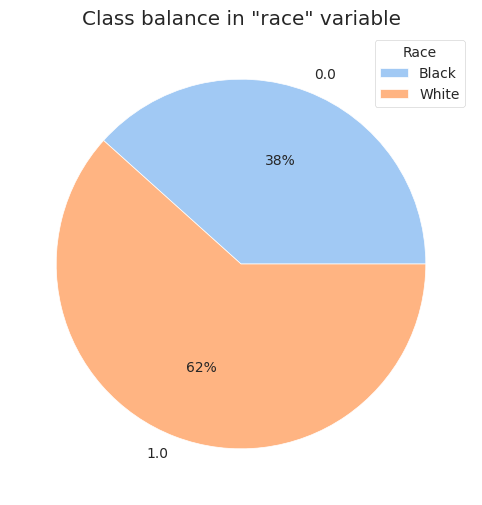

In [53]:
colors = sns.color_palette('pastel')[0:5]
shares = together.groupby('race').size()
legend_labels = ['Black','White']

plt.figure(figsize=(8,6))
plt.pie(shares, labels = shares.index, colors = colors, autopct='%.0f%%')
plt.legend(title='Race', labels=legend_labels, loc='best')
plt.title('Class balance in "race" variable')

в целом, баланс классов сохраняется

___________________________________________